In [1]:
# FIX TRAINING ENVIRONMENT
import sys

print("Python version:", sys.version)

import numpy as np, sklearn
print("NumPy:", np.__version__)
print("sklearn:", sklearn.__version__)

assert np.__version__ == "1.26.4", "NumPy version mismatch! MUST be 1.26.4"
assert sklearn.__version__ == "1.2.2", "Scikit-learn version mismatch! MUST be 1.2.2"

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
NumPy: 1.26.4
sklearn: 1.2.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer # Import SimpleImputer
import joblib

In [3]:
df = pd.read_csv("heart_disease_uci.csv")
df = df.drop(['id', 'dataset'], axis=1, errors='ignore')

In [4]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
df = df.dropna(subset=['num'])  # drop missing target rows

In [6]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [8]:
y = df['num']
X = df.drop('num', axis=1)

In [9]:
import joblib

# Save the exact columns used in training
joblib.dump(list(X.columns), "model_columns.pkl")

print("Columns saved successfully!")
print(X.columns.tolist())

Columns saved successfully!
['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Impute missing values after scaling
imputer = SimpleImputer(strategy='mean') # or 'median', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

In [13]:
models = {
    "LogReg": LogisticRegression(max_iter=500, C=0.7, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=9, p=2),
    "SVM": SVC(kernel='rbf', probability=True, C=2),
    "RF": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    "NB": GaussianNB(),
    "GB": GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=3)
}

results = []
for name, m in models.items():
    m.fit(X_train_res, y_train_res)
    preds = m.predict(X_test_imputed) # Use imputed test data for predictions
    probas = m.predict_proba(X_test_imputed)[:,1] if hasattr(m, "predict_proba") else None # Use imputed test data for probas
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probas) if probas is not None else np.nan
    results.append((name, acc, auc))
    print(f"{name:<10} -> Acc: {acc:.3f} | AUC: {auc:.3f}")

LogReg     -> Acc: 0.826 | AUC: 0.900
KNN        -> Acc: 0.853 | AUC: 0.912
SVM        -> Acc: 0.842 | AUC: 0.913
RF         -> Acc: 0.853 | AUC: 0.916
NB         -> Acc: 0.853 | AUC: 0.896
GB         -> Acc: 0.853 | AUC: 0.909


In [14]:
voting = VotingClassifier(
    estimators=[
        ('rf', models['RF']),
        ('gb', models['GB']),
        ('svm', models['SVM'])
    ],
    voting='soft'
)
voting.fit(X_train_res, y_train_res)
v_preds = voting.predict(X_test_imputed) # Use imputed test data for predictions
v_proba = voting.predict_proba(X_test_imputed)[:,1]
v_acc = accuracy_score(y_test, v_preds)
v_auc = roc_auc_score(y_test, v_proba)

print("\n Ensemble Voting Classifier -> Acc: {:.3f} | AUC: {:.3f}".format(v_acc, v_auc))


 Ensemble Voting Classifier -> Acc: 0.875 | AUC: 0.917


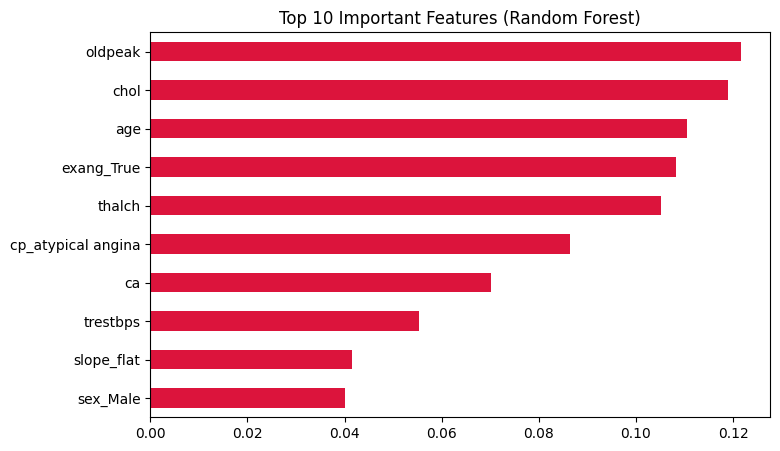

In [15]:
importances = pd.Series(models['RF'].feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.head(10).plot(kind='barh', color='crimson')
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [16]:
sample = pd.DataFrame([[52, 'Male', 'typical angina', 125.0, 212.0, False, 'normal', 168.0, False, 1.0, 'flat', 2.0, 'normal']],
                      columns=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

sample = pd.get_dummies(sample, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], drop_first=True)
for col in X.columns:
    if col not in sample.columns:
        sample[col] = 0
sample = sample[X.columns]
sample_scaled = scaler.transform(sample)
sample_imputed = imputer.transform(sample_scaled) # Impute sample data
pred = voting.predict(sample_imputed)[0] # Predict using imputed sample data
print("\n🩺 Predicted:", "Heart Disease Detected" if pred==1 else "No Heart Disease")


🩺 Predicted: Heart Disease Detected


In [17]:
import joblib

# Save the model, scaler, and columns
joblib.dump(voting, "heart_attack_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X.columns), "model_columns.pkl")

print("Model, scaler, and column names saved successfully!")

Model, scaler, and column names saved successfully!
